# Проведение анализа A/B-тестирования

В крупном интернет-магазине, вместе с отделом маркетинга, был подготовлен список гипотез для увеличения выручки.  
Чтобы не ошибиться в выборе гипотезы, нужно их приоритизировать и провести A/B-тесты.
A/B-тестирование позволяет узнать различие между группами или его отсутствие, сравнивая различные метрики.

Цели:
1. подготовить данные к анализу;  
2. приоритизировать гипотезы;  
3. запустить A/B-тест;  
4. проанализировать результаты.   
  
В ходе работы нужно выполнить следующие задачи: 

- Применить фреймворк ICE и RICE для приоритизации гипотез;  
- Построить график кумулятивной выручки и кумулятивного среднего чека по группам;
- Построить график относительного изменения кумулятивного среднего чека группы B к группе A;
- Построить график кумулятивной конверсии по группам;
- Построить график относительного изменения кумулятивной конверсии группы B к группе A;
- Построить точечные графики количества и стоимостей заказов по пользователям;
- Посчитать 95-й и 99-й перцентили количества и стоимости заказов на пользователя. Выбрать границу для определения аномальных пользователей;
- Посчитать статистическую значимость различий в конверсии между группами по «сырым» и «очищенным» данным;
- Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» и «очищенным» данным;
- Принять решение по результатам теста. 

## Описание данных   
  
Файл /datasets/hypothesis.csv  
- `Hypothesis` — краткое описание гипотезы;  
- `Reach` — охват пользователей по 10-балльной шкале;  
- `Impact` — влияние на пользователей по 10-балльной шкале;  
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;  
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  

Файл /datasets/orders.csv
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

## Изучение данных и подготовка их к анализу

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters 
import scipy.stats as stats
import datetime as dt
import numpy as np
import warnings

In [26]:
pd.options.display.max_colwidth = 150
hypotheses = pd.read_csv('/Users/polina_lunyova/Documents/It/projects/final_version/6_Принятие_решений_в_бизнесе/hypothesis.csv')
orders = pd.read_csv('/Users/polina_lunyova/Documents/It/projects/final_version/6_Принятие_решений_в_бизнесе/orders.csv')
visitors = pd.read_csv('/Users/polina_lunyova/Documents/It/projects/final_version/6_Принятие_решений_в_бизнесе/visitors.csv')
display(hypotheses, orders.head(), visitors.head())

display(hypotheses.info(), orders.info(), visitors.info())
display(hypotheses.describe(), orders.describe(), visitors.describe())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

None

None

,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [27]:
# приведем название столбцов к нижнему регистру
hypotheses = hypotheses.rename(columns=str.lower)

# изменяем названия столбцов
orders = orders.rename(columns = {'transactionId' : 'transaction_id', 'visitorId' : 'visitor_id'}) 

# изменяем тип данных 
visitors['date'] = pd.to_datetime(visitors['date'], format = '%Y-%m-%d')
orders['date'] = pd.to_datetime(orders['date'], format = '%Y-%m-%d')

# определяем пропущенные значения
display(hypotheses.isna().sum())
display(orders.isna().sum())
display(visitors.isna().sum())

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

Пользователи могли попасть в две группы одновременно. Чтобы не искажался результат эксперимента, отфильтруем данные и удалим дублированых пользователей.

In [28]:
# посмотрим количество пользователей, попавших в обе группы
(orders.groupby(['visitor_id']) # группируем по айди
       .agg({'group':'nunique'}) # считаем количество групп для каждого айди
       .query('group > 1')  # выводим результат, где групп больше 1
       .sum() # выводим общее количество
)

group    116
dtype: int64

In [29]:
# отбираем группы из данных с заказами 
group_a = orders.query('group == "A"') 
group_b = orders.query('group == "B"') 
  
# получаем пользователей, попавших в обе группы 
group_intersections = list(np.intersect1d(group_a['visitor_id'], group_b['visitor_id']))
orders = orders.query('visitor_id not in @group_intersections')

##  Приоритизация гипотез. Часть 1

 Гипотезы приоритизируют, чтобы сократить расходы на эксперименты и запускать тестирование только наиболее перспективных идей.  
 Есть два самых популярных способа приоритизации задач: ICE и RICE.  
 Они расчитываются как:  
 ICE = impact х confidence / efforts  
 RICE = reach х impact х confidence / efforts   
 
Reach — скольких пользователей затронет изменение, которое вы хотите внести;  
Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;   
Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;  
Efforts — сколько стоит протестировать эту гипотезу. 

In [30]:
# приоретизируем гипотизы с помощью метода ICE
hypotheses['ICE'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['efforts']

# приоретизируем гипотизы с помощью метода RICE
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['efforts']

# визуализация таблицы
np.random.seed(0)
hypotheses.style

display(hypotheses[['hypothesis', 'ICE', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.0


Наиболее перспективные гипотезы по ICE: 8, 0, 7.   
Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6. 

Приоритизация гипотез при применении RICE вместо ICE изменилась. Гипотеза 7 возглавила список по приоритетности т.к. ее параметр 'reach'(количество затронутых пользователей при изменении продукта) равен 10.

##  Анализ A/B-теста. Часть 2

In [31]:
# построим график кумулятивной выручки по группам
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                                     .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}),
                                     axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}),
                                       axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(orders.head(5))
display(cumulativeData.head(5))

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


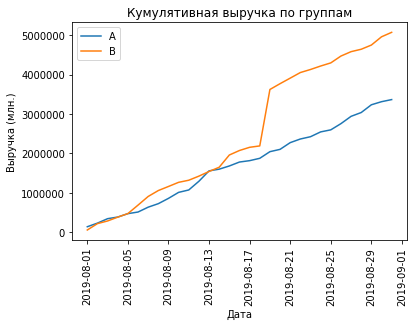

In [32]:
# построим график кумулятивной выручки по группам
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Кумулятивная выручка по группам')
plt.ylabel('Выручка (млн.)')
plt.xlabel('Дата')
plt.legend()
plt.xticks(rotation=90)
plt.show()

В середине теста группа "В" вырвалась вперед и продолжала лидировать весь остаток теста. 
Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

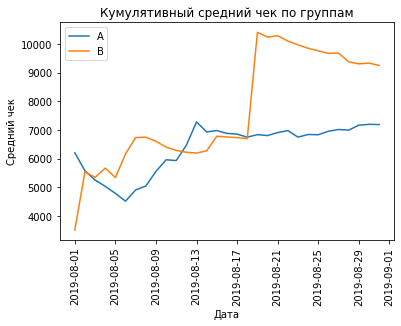

In [33]:
# построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('Кумулятивный средний чек по группам')
plt.ylabel('Cредний чек')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()


Кумулятивное значение среднего чека по группам не равномерен на протяжении всего теста. Возможно, в группу B во второй половине теста попали крупные заказы (резкий всплеск на графике). Скорее всего, принимать решение по этой метрике рано. Требуется дополнительный анализ выбросов, которые так сильно искажают результаты.

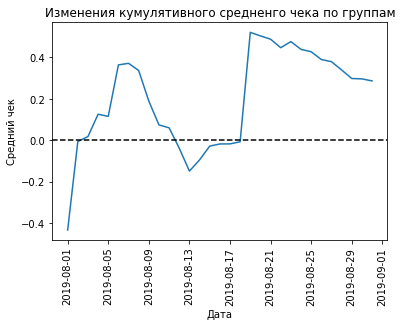

In [34]:
# построим график относительного изменения кумулятивного среднего чека группы B к группе A
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Изменения кумулятивного средненго чека по группам')
plt.ylabel('Cредний чек')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()


Результаты теста нескольких датах резко меняются. Значит именно тогда были совершены аномальные заказы.

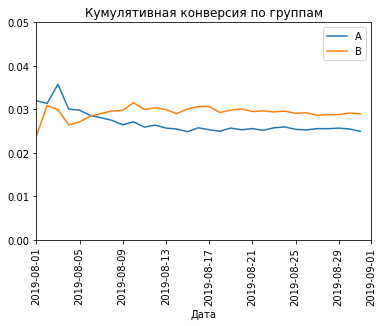

In [35]:
# построим график кумулятивной конверсии по группам
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
plt.title('Кумулятивная конверсия по группам')
plt.ylabel('')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

В начале теста группа "А" имела большую конверсию, но позже группа "В" переросла ее и зафиксировалась примерно на одном значении. 

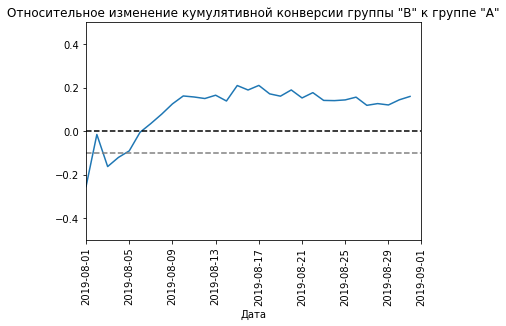

In [36]:
# Построим график относительного различия кумулятивных конверсий
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1),  -0.5, 0.5])
plt.title('Относительное изменение кумулятивной конверсии группы "B" к группе "A"')
plt.ylabel('')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.show()

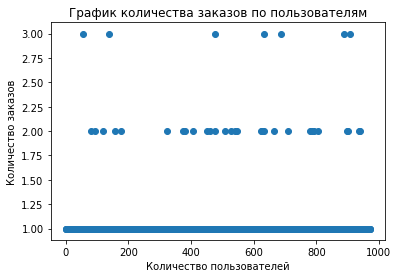

In [37]:
# построим точечный график количества заказов по пользователям
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsers.columns = ['visitor_id', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('График количества заказов по пользователям')
plt.ylabel('Количество заказов')
plt.xlabel('Количество пользователей')
plt.show()

Большинство пользователей сделало до 2-х заказов. Остальные пользователли вполне могут быть аномальными. Далее посчитаем перцентили, чтобы точнее определить границу аномальных пользователей.

In [38]:
# посчитаем 95-й и 99-й перцентили количества заказов на пользователя
print(np.percentile(ordersByUsers['orders'], [95, 99]))  

[1. 2.]


Не более 5% пользователей совершали больше 1 заказа и не более 1% пользователей более 2-х заказов.
Разумно будет определить пользователей, совершивших более 1 заказа аномальными.

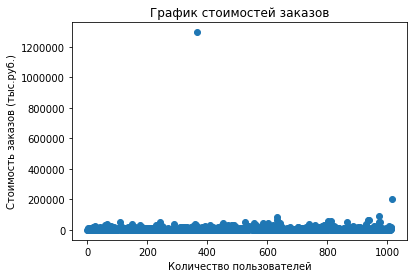

In [39]:
# построим точечный график стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('График стоимостей заказов')
plt.ylabel('Стоимость заказов (тыс.руб.)')
plt.xlabel('Количество пользователей')
plt.show()

Заказы в основном до 100 тыс.руб. Есть небольшие выбросы до 200 тыс.руб. и 1250 тыс.руб., но их не так много.

In [40]:
# посчитаем 95-й и 99-й перцентили стоимости заказов
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более, чем у 5% заказов чек дороже 27 тыс.руб. И не больше, чем у 1% заказов дороже 54 тыс.руб. Будет разумно определить границу пользователей с аномальными заказами больше 27 тыс.руб.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы:  
Нулевая(H0) - различий в конверсии между группами нет.  
Альтернативная(H1) - различия в конверсии между группами есть.

In [41]:
# посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

# посчитаем статистическую значимость различия в конверсии между группами
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['transaction_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['transaction_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Oтносительный прирост конверсии группы B:', "{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))


,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


p-value: 0.00551
Oтносительный прирост конверсии группы B: 0.160


Отвергаем нулевую гепотезу т.к. значение р-value = 0.00551 (это значительно меньше 0.05). Анализ "сырых данных" сообщает, что в конверсии между группами A и B есть статистически значимые различия. Относительный прирост конверсии группы В к конверсии группы А равен 16%

In [42]:
# посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Oтносительный прирост среднего чека группы B:', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.415
Oтносительный прирост среднего чека группы B: 0.287


Р-value значительно больше 0.05, значит статистически значимых отличий в среднем чеке между группами нет. Наблюдаемое различие в 28.7% не является статистически значимым.

In [43]:
# узнаем, сколько всего аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['transaction_id'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['transaction_id'],
    ],
    axis=0,
)
revenue_lim = 27000
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['transaction_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
print('Количество аномальных пользователей:', abnormalUsers.shape[0])

33      249864742
1099    316924019
551     323958042
1087    324171086
751     348143148
Name: transaction_id, dtype: int64

Количество аномальных пользователей: 87


In [44]:
# посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным
# подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['transaction_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['transaction_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
# применим статистический критерий Манна-Уитни к полученным выборкам
print('p-value:', '{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Oтносительный прирост конверсии очищенной группы B:', '{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.00469
Oтносительный прирост конверсии очищенной группы B: 0.183


Как и в случае с "сырыми" данными статистическая значимость достигнута. Сегмент В значительно лучше сегмента А.

In [45]:
# посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

print('p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['transaction_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['transaction_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Oтносительный прирост среднего чека очищенной группы B:',  
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['transaction_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['transaction_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.349
Oтносительный прирост среднего чека очищенной группы B: -0.059


P-value увеличился, но и разница между сегментами значительно сократилась с 28% до 2%

Промежуточные выводы по тесту:  
- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий;  
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;  
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A: показалели группы В в последней трети эксперимента выросли и стабилизировались;  
- График различия среднего чека колеблется: он и позволил нам найти аномалии.

## Вывод

По результатам приоритизации можно выделить следующие гипотезы:  
№ 7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;  
№ 0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей. 

Во время проведения A/B-теста были обнаружены аномальные значения.  
В начале теста группа "А" имела большую конверсию, но позже группа "В" переросла ее и остальную треть эксперимента была стабилизирована.  
В основном пользователи совершали до 1-го заказа на сумму до 27 тыс.руб., остальные значения были признаны как аномальные.  
По результатам теста сегмент В был признан лучше сегмента А.  
